# 0. Create Kaggle API

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"juliustembrockhaus","key":"8d6805f5cbb36cf612db7e3d112d5240"}'}

In [0]:
!ls -lha kaggle.json #make sure the kaggle.json file is present

-rw-r--r-- 1 root root 74 May  5 10:42 kaggle.json


In [0]:
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
# List available datasets.
!kaggle datasets list

ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge           COVID-19 Open Research Dataset Challenge (CORD-19)    2GB  2020-05-02 20:35:01          61510  
divyansh22/us-border-crossing-data                          US Border Crossing Data                               2MB  2020-04-19 09:38:10            936  
roche-data-science-coalition/uncover                        UNCOVER COVID-19 Challenge                          142MB  2020-04-29 22:47:23           6877  
baltacifatih/turkish-lira-banknote-dataset                  Turkish Lira Banknote Dataset                         3GB  2020-04-19 14:48:39             92  
doaaalsenani/usa-cers-dataset                               US C

In [0]:
!kaggle datasets download -d allen-institute-for-ai/CORD-19-research-challenge
!ls

100% 1.70G/1.70G [00:16<00:00, 128MB/s]
100% 1.70G/1.70G [00:16<00:00, 112MB/s]
CORD-19-research-challenge.zip	drive  kaggle.json  sample_data


In [0]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!mkdir -p '/content/drive/My Drive/Colab Notebooks/DSLS/week3/input'

In [0]:
!unzip /content/CORD-19-research-challenge.zip -d '/content/drive/My Drive/Colab Notebooks/DSLS/week3/input/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/My Drive/Colab Notebooks/DSLS/week3/input/custom_license/custom_license/pmc_json/PMC7180654.xml.json  
  inflating: /content/drive/My Drive/Colab Notebooks/DSLS/week3/input/custom_license/custom_license/pmc_json/PMC7180657.xml.json  
  inflating: /content/drive/My Drive/Colab Notebooks/DSLS/week3/input/custom_license/custom_license/pmc_json/PMC7180659.xml.json  
  inflating: /content/drive/My Drive/Colab Notebooks/DSLS/week3/input/custom_license/custom_license/pmc_json/PMC7180660.xml.json  
  inflating: /content/drive/My Drive/Colab Notebooks/DSLS/week3/input/custom_license/custom_license/pmc_json/PMC7180661.xml.json  
  inflating: /content/drive/My Drive/Colab Notebooks/DSLS/week3/input/custom_license/custom_license/pmc_json/PMC7180663.xml.json  
  inflating: /content/drive/My Drive/Colab Notebooks/DSLS/week3/input/custom_license/custom_license/pmc_json/PMC7180664.xml.json  
  inflating: /content/drive/My D

# 1. Loading the Data


## 1.1 Import required packages

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## 1.2 Load Metadata

In [0]:
# mount the drive (if not already did)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
root_path = '/content/drive/My Drive/Colab Notebooks/DSLS/week3/input/'
metadata_path = f'{root_path}/metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,arxiv_id,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,zjufx4fo,b2897e1277f56641193a6db73825f707eed3e4c9,PMC,Sequence requirements for RNA strand transfer ...,10.1093/emboj/20.24.7220,PMC125340,11742998,unk,Nidovirus subgenomic mRNAs contain a leader se...,2001-12-17,"Pasternak, Alexander O.; van den Born, Erwin; ...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc125340?pdf=re...
1,ymceytj3,e3d0d482ebd9a8ba81c254cc433f314142e72174,PMC,"Crystal structure of murine sCEACAM1a[1,4]: a ...",10.1093/emboj/21.9.2076,PMC125375,11980704,unk,CEACAM1 is a member of the carcinoembryonic an...,2002-05-01,"Tan, Kemin; Zelus, Bruce D.; Meijers, Rob; Liu...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc125375?pdf=re...
2,wzj2glte,00b1d99e70f779eb4ede50059db469c65e8c1469,PMC,Synthesis of a novel hepatitis C virus protein...,10.1093/emboj/20.14.3840,PMC125543,11447125,no-cc,Hepatitis C virus (HCV) is an important human ...,2001-07-16,"Xu, Zhenming; Choi, Jinah; Yen, T.S.Benedict; ...",EMBO J,NaN,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
3,2sfqsfm1,cf584e00f637cbd8f1bb35f3f09f5ed07b71aeb0,PMC,Structure of coronavirus main proteinase revea...,10.1093/emboj/cdf327,PMC126080,12093723,unk,The key enzyme in coronavirus polyprotein proc...,2002-07-01,"Anand, Kanchan; Palm, Gottfried J.; Mesters, J...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc126080?pdf=re...
4,i0zym7iq,dde02f11923815e6a16a31dd6298c46b109c5dfa,PMC,Discontinuous and non-discontinuous subgenomic...,10.1093/emboj/cdf635,PMC136939,12456663,unk,"Arteri-, corona-, toro- and roniviruses are ev...",2002-12-01,"van Vliet, A.L.W.; Smits, S.L.; Rottier, P.J.M...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc136939?pdf=re...


In [0]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59887 entries, 0 to 59886
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   cord_uid                     59887 non-null  object
 1   sha                          45763 non-null  object
 2   source_x                     59887 non-null  object
 3   title                        59724 non-null  object
 4   doi                          55801 non-null  object
 5   pmcid                        48139 non-null  object
 6   pubmed_id                    41328 non-null  object
 7   license                      59887 non-null  object
 8   abstract                     48757 non-null  object
 9   publish_time                 59879 non-null  object
 10  authors                      57296 non-null  object
 11  journal                      52828 non-null  object
 12  Microsoft Academic Paper ID  964 non-null    object
 13  WHO #Covidence               17

In [0]:
all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)
len(all_json)

71261

## 1.3 Define Helper functions

### 1.3.1 File Reader Class


In [0]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])
print(first_row)

003d2e515e1aaf06f0052769953e861ed8e56608: ... It is highly contagious, and severe cases can lead to acute respiratory distress or multiple organ failure [3] . On 11 March 2020, the WHO has made the assessment that COVID-19 can be characterised as...


## 1.3.1 Function for word breaks

This functioin adds break after every words when character length reach to certain amount. This is for the interactive plot so that hover tool fits the screen.

In [0]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

## 1.4 Load the Data into DataFrame

In [0]:
dict_ = {'paper_id': [], 'doi':[], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 100 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # if more than 2 authors, take them all with html tag breaks in between
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
    # add doi
    dict_['doi'].append(meta_data['doi'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

Processing index: 0 of 71261
Processing index: 7126 of 71261
Processing index: 14252 of 71261
Processing index: 21378 of 71261
Processing index: 28504 of 71261
Processing index: 35630 of 71261
Processing index: 42756 of 71261
Processing index: 49882 of 71261
Processing index: 57008 of 71261
Processing index: 64134 of 71261
Processing index: 71260 of 71261


,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary
0,003d2e515e1aaf06f0052769953e861ed8e56608,NaN,,"It is highly contagious, and severe cases can ...",Shaoping Hu. Yuan Gao. Zhangming Niu. Ying...,Weakly Supervised Deep Learning for COVID-19<...,NaN,Not provided.
1,00a407540a8bdd6d7425bd8a561eb21d69682511,NaN,Rapidly developed AI-based automated CT image ...,• For Coronavirus patients the system outputs ...,Ophir Gozes. Maayan Frid-Adar. Hayit<br>Gre...,Rapid AI Development Cycle for the Coronaviru...,NaN,Rapidly developed AI-based automated CT image...
2,00c386ee8b9fac7eeb2291a72d52966d83eec814,NaN,It is shown that the evaporation rate of a liq...,It is shown that the evaporation rate of a liq...,P. Grinchuk S.. E. Fisenko I.. S. Fisenko P...,Isothermal evaporation rate of deposited<br>l...,NaN,It is shown that the evaporation rate of a li...
3,024b30561568979f525d8b2580f85122c02008a0,NaN,A model of reactive social distancing in epide...,Let the proportions of a population who are su...,Rose Baker,Reactive Social distancing in a SIR model of<...,NaN,A model of reactive social distancing in<br>e...
4,02b3c0c87a6b32d5107a6e05f83f73cb7f939432,NaN,Large scale disease screening is a complicated...,In many cohort studies specimens collected fro...,Gregory Haber. Yaakov Malinovsky. Paul Albe...,Is Group Testing Ready for Prime-time in<br>D...,NaN,Large scale disease screening is a complicate...


## 1.5 Some feature engineering

In [0]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
df_covid['body_unique_words']=df_covid['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df_covid.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
0,003d2e515e1aaf06f0052769953e861ed8e56608,NaN,,"It is highly contagious, and severe cases can ...",Shaoping Hu. Yuan Gao. Zhangming Niu. Ying...,Weakly Supervised Deep Learning for COVID-19<...,NaN,Not provided.,0,4007,1408
1,00a407540a8bdd6d7425bd8a561eb21d69682511,NaN,Rapidly developed AI-based automated CT image ...,• For Coronavirus patients the system outputs ...,Ophir Gozes. Maayan Frid-Adar. Hayit<br>Gre...,Rapid AI Development Cycle for the Coronaviru...,NaN,Rapidly developed AI-based automated CT image...,102,2060,819
2,00c386ee8b9fac7eeb2291a72d52966d83eec814,NaN,It is shown that the evaporation rate of a liq...,It is shown that the evaporation rate of a liq...,P. Grinchuk S.. E. Fisenko I.. S. Fisenko P...,Isothermal evaporation rate of deposited<br>l...,NaN,It is shown that the evaporation rate of a li...,119,3140,943
3,024b30561568979f525d8b2580f85122c02008a0,NaN,A model of reactive social distancing in epide...,Let the proportions of a population who are su...,Rose Baker,Reactive Social distancing in a SIR model of<...,NaN,A model of reactive social distancing in<br>e...,53,952,426
4,02b3c0c87a6b32d5107a6e05f83f73cb7f939432,NaN,Large scale disease screening is a complicated...,In many cohort studies specimens collected fro...,Gregory Haber. Yaakov Malinovsky. Paul Albe...,Is Group Testing Ready for Prime-time in<br>D...,NaN,Large scale disease screening is a complicate...,1255,4439,1121


In [0]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43331 entries, 0 to 43330
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             43331 non-null  object
 1   doi                  42267 non-null  object
 2   abstract             43331 non-null  object
 3   body_text            43331 non-null  object
 4   authors              42635 non-null  object
 5   title                43293 non-null  object
 6   journal              39612 non-null  object
 7   abstract_summary     43331 non-null  object
 8   abstract_word_count  43331 non-null  int64 
 9   body_word_count      43331 non-null  int64 
 10  body_unique_words    43331 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 3.6+ MB


In [0]:
df_covid['abstract'].describe(include='all')

count     43331
unique    30960
top            
freq      12271
Name: abstract, dtype: object

## 1.6 Data summary

In [0]:
df_covid.describe()

,abstract_word_count,body_word_count,body_unique_words
count,43331.000000,43331.000000,43331.000000
mean,157.279153,4528.416976,1376.929773
std,174.905494,7063.770032,1188.811274
min,0.000000,1.000000,1.000000
25%,0.000000,2178.000000,846.000000
50%,153.000000,3484.000000,1193.000000
75%,233.000000,5269.000000,1635.000000
max,5370.000000,268982.000000,38298.000000


# 2. Data Pre-processing

## 2.1 Remove duplicates

When we look at the unique values above, we can see that tehre are duplicates. It may have caused because of author submiting the article to multiple journals. 

In [0]:
df_covid.drop_duplicates(['abstract', 'body_text'], inplace=True)
df_covid['abstract'].describe(include='all')

count     43299
unique    30960
top            
freq      12254
Name: abstract, dtype: object

In [0]:
df_covid['body_text'].describe(include='all')

count                              43299
unique                             43290
top       J o u r n a l P r e -p r o o f
freq                                   3
Name: body_text, dtype: object

It looks like we didn't have duplicates. Instead, it was articles without Abstracts.

## 2.2 Limiting the dataset

To reduce the runtime, we limit the dataset to 10.000 instances (as they did in the Kaggle notebook).

In [0]:
df = df_covid.sample(10000, random_state=42)
del df_covid

## 2.3 Drop Null values

In [0]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8927 entries, 12404 to 21883
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             8927 non-null   object
 1   doi                  8927 non-null   object
 2   abstract             8927 non-null   object
 3   body_text            8927 non-null   object
 4   authors              8927 non-null   object
 5   title                8927 non-null   object
 6   journal              8927 non-null   object
 7   abstract_summary     8927 non-null   object
 8   abstract_word_count  8927 non-null   int64 
 9   body_word_count      8927 non-null   int64 
 10  body_unique_words    8927 non-null   int64 
dtypes: int64(3), object(8)
memory usage: 836.9+ KB


## 2.4 Handling multiple languages

Next we are going to determine the language of each paper in the dataframe. Not all of the sources are English and the language needs to be identified so that we know how to handle these instances.

### 2.4.1 Language detection

In [0]:
!pip install langdetect
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

     |████████████████████████████████| 983kB 2.6MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993193 sha256=d75cc7691ccadd9ec9e5442ca42779f5fd3b95dd7abe61c9ad065be79167ff4b
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [0]:
# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|██████████| 8927/8927 [00:45<00:00, 194.19it/s]


In [0]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 8927

{'af': 1,
 'ca': 1,
 'cy': 2,
 'de': 25,
 'en': 8685,
 'es': 103,
 'fr': 89,
 'it': 5,
 'nl': 12,
 'pt': 3,
 'ro': 1}


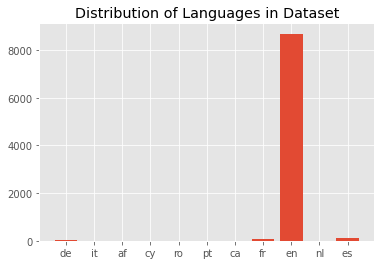

In [0]:
df['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()

### 2.4.2 Drop any language that is not English

In [0]:
df = df[df['language'] == 'en'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8685 entries, 12404 to 21883
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             8685 non-null   object
 1   doi                  8685 non-null   object
 2   abstract             8685 non-null   object
 3   body_text            8685 non-null   object
 4   authors              8685 non-null   object
 5   title                8685 non-null   object
 6   journal              8685 non-null   object
 7   abstract_summary     8685 non-null   object
 8   abstract_word_count  8685 non-null   int64 
 9   body_word_count      8685 non-null   int64 
 10  body_unique_words    8685 non-null   int64 
 11  language             8685 non-null   object
dtypes: int64(3), object(9)
memory usage: 882.1+ KB


## 2.5 Stopwords

Stopwords = common words that will act as noise in the clustering step

### 2.5.1 Stopword detection

In [0]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string

In [0]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

["'d",
 'out',
 'however',
 'some',
 'twelve',
 'become',
 'even',
 'everywhere',
 'then',
 'enough']

### 2.5.2 Add custom stopwords

In [0]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

## 2.6 Process the text

For this purpose we will be using the spacy library. This function will convert text to lower case, remove punctuation, and find and remove stopwords. For the parser, we will use en_core_sci_lg. This is a model for processing biomedical, scientific or clinical text.

### 2.6.1 Install required packages

In [0]:
# Download the spacy bio parser
from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

In [0]:
#NLP 
import en_core_sci_lg  # model downloaded in previous step

### 2.6.2 Define the parser

In [0]:
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

### 2.6.3 Applying the text-processing function on the body_text

In [0]:
tqdm.pandas()
df["processed_text"] = df["body_text"].progress_apply(spacy_tokenizer)

100%|██████████| 8685/8685 [1:09:59<00:00,  2.07it/s]


## 2.7 Investigate word count

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


count      8685.000000
mean       4468.734830
std        5375.443656
min          13.000000
25%        2339.000000
50%        3611.000000
75%        5342.000000
max      188793.000000
Name: body_word_count, dtype: float64

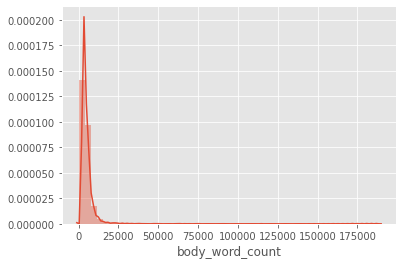

In [0]:
import seaborn as sns
sns.distplot(df['body_word_count'])
df['body_word_count'].describe()

count     8685.000000
mean      1383.699021
std        961.296124
min         13.000000
25%        891.000000
50%       1231.000000
75%       1657.000000
max      25156.000000
Name: body_unique_words, dtype: float64

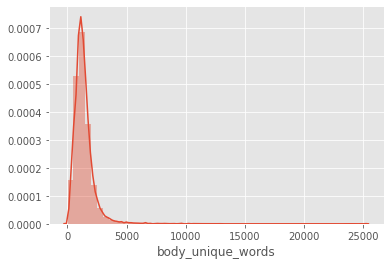

In [0]:
sns.distplot(df['body_unique_words'])
df['body_unique_words'].describe()

These two plots give us a good idea of the content we are dealing with. Most papers are about 5000 words in length. The long tails in both plots are caused by outliers. In fact, ~98% of the papers are under 20,000 words in length while a select few are over 200,000!

# 3. Vectorization

Now that we have pre-processed the data, it is time to convert it into a format that can be handled by our algorithms. For this purpose we will be using tf-idf. This will convert our string formatted data into a measure of how important each word is to the instance out of the literature as a whole. <br>
We will be clustering based on the content of the body text. The maximum number of features will be limited. **Only the top 2^12 features** will be used, eseentially acting as a **noise filter**. Additionally, more features cause painfully long runtimes.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [0]:
text = df['processed_text'].values
X = vectorize(text, 2 ** 12)
X.shape

(8685, 4096)

# 4. PCA and Clustering

Let's see how much we can reduce the dimensions while still keeping 95% variance. We will apply Principle Component Analysis (PCA) to our vectorized data. The reason for this is that by keeping a large number of dimensions with PCA, you don’t destroy much of the information, but hopefully will remove some noise/outliers from the data, and make the clustering problem easier for k-means. Note that X_reduced will only be used for k-means, t-SNE will still use the original feature vector X that was generated through tf-idf on the NLP processed text.

## 4.1 PCA

In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(8685, 2112)

## 4.2 K-Means Clustering

To separate the literature, k-means will be run on the vectorized text. Given the number of clusters, k, k-means will categorize each vector by taking the mean distance to a randomly initialized centroid. The centroids are updated iteratively.

### 4.2.1 Determine best k (number of clusters)

In [0]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from tqdm import tqdm

In [0]:
# run kmeans with many different k
distortions = []
K = range(2, 50)
for k in tqdm(K):
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

100%|██████████| 48/48 [1:46:34<00:00, 133.22s/it]


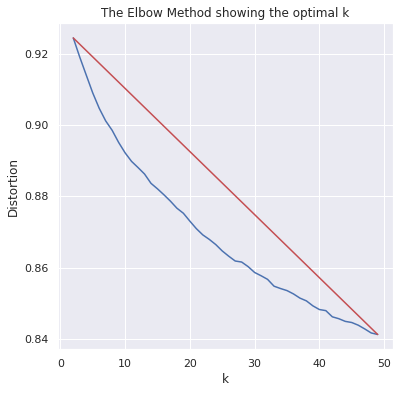

In [185]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.figure(figsize=(6,6))
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In the plot above the elbow is at k=27 indicating the optimal number of clusters for this dataset is 27.

### 4.2.2 Run k-means

In [0]:
k = 27
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

# 5. Dimensionality reduction

Using t-Distributed Stochastic Neighbor Embedding (t-SNE) we can reduce our high dimensional features vector to 2 dimensions. By using the 2 dimensions as x,y coordinates, the body_text can be plotted.

## 5.1 Reduce to 2 dimensions

In [0]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 8685 samples in 6.648s...
[t-SNE] Computed neighbors for 8685 samples in 698.231s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8685
[t-SNE] Computed conditional probabilities for sample 2000 / 8685
[t-SNE] Computed conditional probabilities for sample 3000 / 8685
[t-SNE] Computed conditional probabilities for sample 4000 / 8685
[t-SNE] Computed conditional probabilities for sample 5000 / 8685
[t-SNE] Computed conditional probabilities for sample 6000 / 8685
[t-SNE] Computed conditional probabilities for sample 7000 / 8685
[t-SNE] Computed conditional probabilities for sample 8000 / 8685
[t-SNE] Computed conditional probabilities for sample 8685 / 8685
[t-SNE] Mean sigma: 0.375939
[t-SNE] KL divergence after 50 iterations with early exaggeration: 80.790909
[t-SNE] KL divergence after 1000 iterations: 1.816281


## 5.2 Plot t-SNE results (no labels)

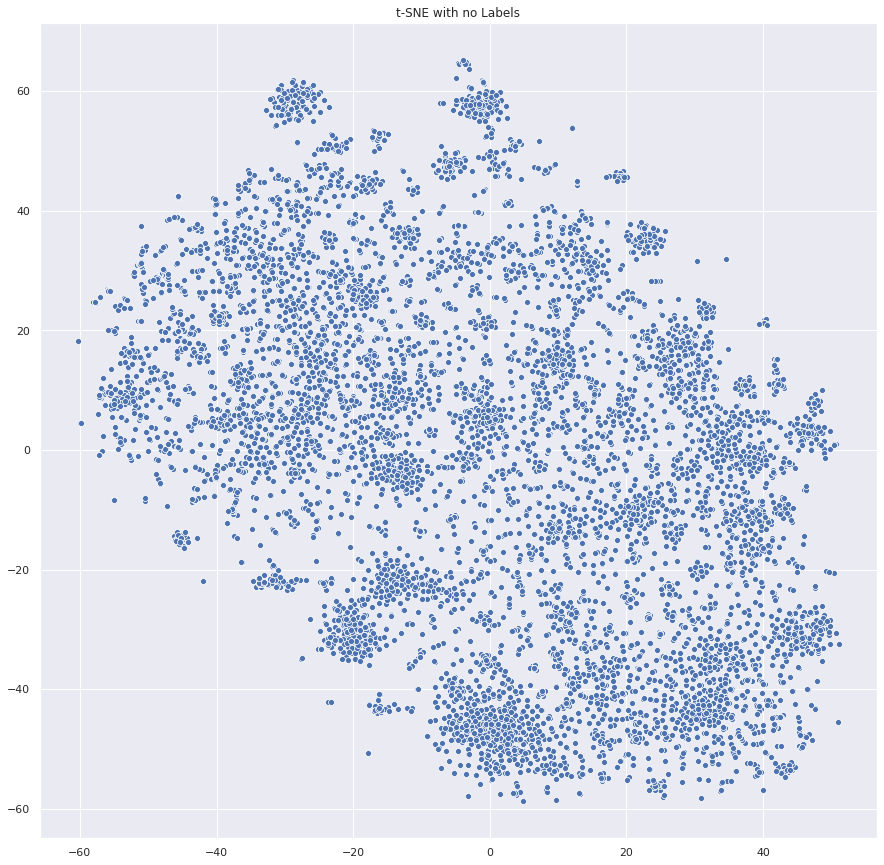

In [0]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()

## 5.3 Add labels from k-means results

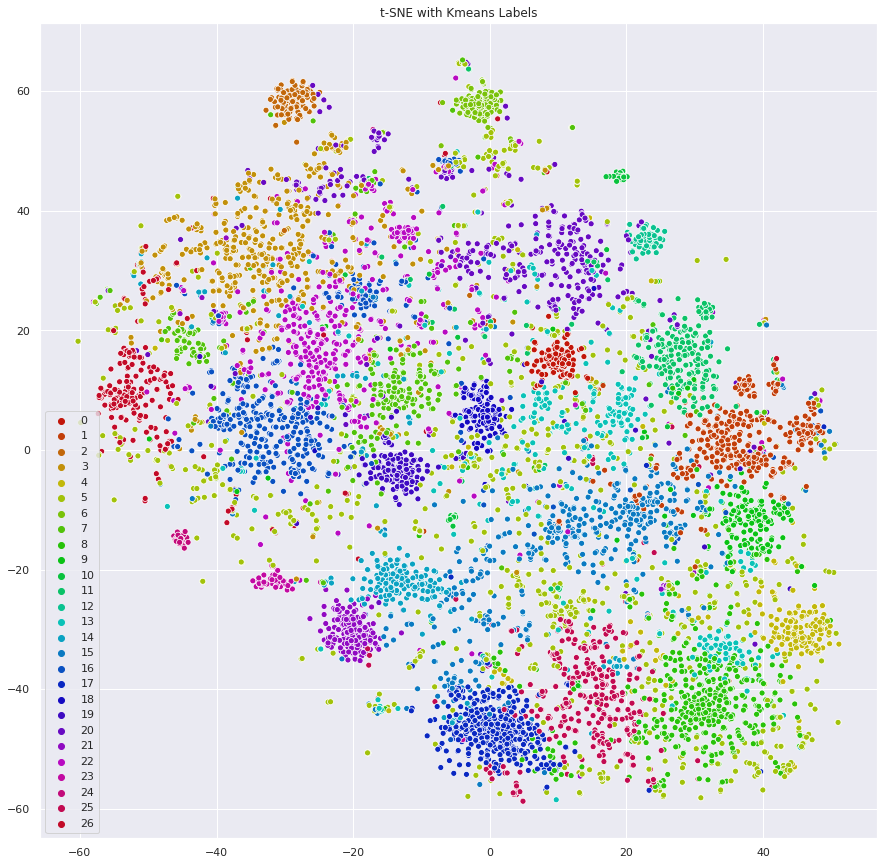

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(k, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

### 5.4 Explanation

The labeled plot gives better insight into how the papers are grouped. It is interesting that both k-means and t-SNE are able to agree on certain clusters even though they were ran independetly. The location of each paper on the plot was determined by t-SNE while the label (color) was determined by k-means. If we look at a particular part of the plot where t-SNE has grouped many articles forming a cluster, it is likely that k-means is uniform in the labeling of this cluster (most of the cluster is the same color). This behavior shows that structure within the literature can be observed and measured to some extent.

Now there are other cases where the colored labels (k-means) are spread out on the plot (t-SNE). This is a result of t-SNE and k-means finding different connections in the higher dimensional data. The topics of these papers often intersect so it hard to cleanly separate them. This effect can be observed in the formation of subclusters on the plot. These subclusters are a conglomeration of different k-means labels but may share some connection determined by t-SNE.

This organization of the data does not act as a simple search engine. The clustering + dimensionality reduction is performed on the mathematical similarities of the publications. As an unsupervised approach, the algorithms may even find connections that were unnaparent to humans. This may highlight hidden shared information and advance further research.

# 6. Topic Modeling on Each Cluster

K-means clustered the articles but did not label the topics. Through topic modeling we will find out what the most important terms for each cluster are. This will add more meaning to the cluster by giving keywords to quickly identify the themes of the cluster.

## 6.1 Latent Dirichment Analysis (LDA)

In LDA, each document can be described by a distribution of topics and each topic can be described by a distribution of words.

### 6.1.1 Create vectorizers for each cluster 

In [0]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
vectorizers = []
    
for ii in range(0, k):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [0]:
vectorizers[0]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=None, min_df=5,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}',
                tokenizer=None, vocabulary=None)

### 6.1.2 Vectorize the data from each cluster

In [0]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [0]:
len(vectorized_data)

27

### 6.1.3 Perform LDA

For each cluster, we create a correspoding LDA model with the top 20 topics per cluster.

In [0]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 20

lda_models = []
for ii in range(0, k):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=False)

### 6.1.4 Fit-ransform LDA models on their respective cluster vectors

In [0]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

### 6.1.5 Extracts the keywords from each cluster

In [0]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [0]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

In [0]:
all_keywords[0][:10]

['cattle',
 'group',
 'diarrhea',
 'concentration',
 'pneumonia',
 'infection',
 'strain',
 'wean',
 'risk',
 'vaccine']

In [0]:
len(all_keywords)

27

# 7. Save outputs to file

Re-running some parts of the notebook (especially vectorization and t-SNE) are time intensive tasks. We want to make sure that the important outputs for generating the bokeh plot are saved for future use.

In [0]:
f=open('/content/drive/My Drive/Colab Notebooks/DSLS/week3/output/topics.txt','w+')

count = 0

for ii in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1

f.close()

In [0]:
import pickle

# save the COVID-19 DataFrame, too large for github
pickle.dump(df, open("/content/drive/My Drive/Colab Notebooks/DSLS/week3/output/df_covid.p", "wb" )) 

# save the final t-SNE
pickle.dump(X_embedded, open("/content/drive/My Drive/Colab Notebooks/DSLS/week3/output/X_embedded.p", "wb" ))

# save the labels generate with k-means(20)
pickle.dump(y_pred, open("/content/drive/My Drive/Colab Notebooks/DSLS/week3/output/y_pred.p", "wb" ))

# 8. Classification (for evaluation)

Though arbitrary, after running kmeans, the data is now 'labeled'. This means that we now use supervised learning to see how well the clustering generalizes. This is just one way to evaluate the clustering. If k-means was able to find a meaningful split in the data, it should be possible to train a classifier to predict which cluster a given instance should belong to.

## 8.1 Define classification report function

In [0]:
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")

## 8.2 Split data into train/test sets

In [0]:
from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(X.toarray(),y_pred, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 6948
X_test size: 1737 



### 8.3 Train the model

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=4)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  87.766 %
     Precision:  90.573 %
        Recall:  89.118 %
      F1 score:  89.717 %


## 8.4 Test the model

In [0]:
# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Test Set)", y_test, sgd_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Stochastic Gradient Descent Report (Test Set) :

Accuracy Score:  81.290 %
     Precision:  87.535 %
        Recall:  79.478 %
      F1 score:  82.263 %


## 8.5 Generalize across the whole dataset

In [0]:
sgd_cv_score = cross_val_score(sgd_clf, X.toarray(), y_pred, cv=10)
print("Mean cv Score - SGD: {:,.3f}".format(float(sgd_cv_score.mean()) * 100), "%")

Mean cv Score - SGD: 89.211 %


# 9. Plotting the data

The previous steps have given us clustering labels and a dataset of papers reduced to two dimensions. By pairing this with Bokeh, we can create an interactive plot of the literature. This should organize the papers such that related publications are in close proximity. To try to undertstand what the similarities may be, we have also performed topic modelling on each cluster of papers in order to pick out the key terms.

Bokeh will pair the actual papers with their positions on the t-SNE plot. Through this approach it will be easier to see how papers fit together, allowing for both exploration of the dataset and evaluation of the clustering.

## 9.1 Import required packages

In [0]:
import os

# change into lib directory to load plot python scripts
main_path = os.getcwd()
lib_path = '/content/drive/My Drive/Colab Notebooks/DSLS/week3/input/kaggle-resources'
os.chdir(lib_path)

In [0]:
# required libraries for plot
from call_backs import input_callback, selected_code  # file with customJS callbacks for bokeh
                                                      # github.com/MaksimEkin/COVID19-Literature-Clustering/blob/master/lib/call_backs.py
import bokeh
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, Slider, TapTool, TextInput
from bokeh.palettes import turbo
from bokeh.transform import linear_cmap, transform
from bokeh.io import output_file, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import RadioButtonGroup, TextInput, Div, Paragraph
from bokeh.layouts import column, widgetbox, row, layout
from bokeh.layouts import column

In [0]:
# go back
os.chdir(main_path)

## 9.2 Load keywords per cluster

In [0]:
import os

topic_path = '/content/drive/My Drive/Colab Notebooks/DSLS/week3/output/topics.txt'
with open(topic_path) as f:
    topics = f.readlines()

## 9.3 Setup

In [0]:
# show on notebook
output_notebook()
# target labels
y_labels = y_pred

# data sources
source = ColumnDataSource(data=dict(
    x= X_embedded[:,0], 
    y= X_embedded[:,1],
    x_backup = X_embedded[:,0],
    y_backup = X_embedded[:,1],
    desc= y_labels, 
    titles= df['title'],
    authors = df['authors'],
    journal = df['journal'],
    abstract = df['abstract_summary'],
    labels = ["C-" + str(x) for x in y_labels],
    links = df['doi']
    ))

# hover over information
hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Author(s)", "@authors{safe}"),
    ("Journal", "@journal"),
    ("Abstract", "@abstract{safe}"),
    ("Link", "@links")
],
point_policy="follow_mouse")

# map colors
mapper = linear_cmap(field_name='desc', 
                     palette=turbo(k),
                     low=min(y_labels) ,high=max(y_labels))

# prepare the figure
plot = figure(plot_width=1200, plot_height=850, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset', 'save', 'tap'], 
           title="Clustering of the COVID-19 Literature with t-SNE and K-Means", 
           toolbar_location="above")

# plot settings
plot.scatter('x', 'y', size=5, 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          line_color="black",
          legend = 'labels')
plot.legend.background_fill_alpha = 0.6

## 9.4 Widgets

In [0]:
# Keywords
text_banner = Paragraph(text= 'Keywords: Slide to specific cluster to see the keywords.', height=45)
input_callback_1 = input_callback(plot, source, text_banner, topics)

# currently selected article
div_curr = Div(text="""Click on a plot to see the link to the article.""",height=150)
callback_selected = CustomJS(args=dict(source=source, current_selection=div_curr), code=selected_code())
taptool = plot.select(type=TapTool)
taptool.callback = callback_selected

# WIDGETS
slider = Slider(start=0, end=k, value=k, step=1, title="Cluster #", callback=input_callback_1)
keyword = TextInput(title="Search:", callback=input_callback_1)

# pass call back arguments
input_callback_1.args["text"] = keyword
input_callback_1.args["slider"] = slider

## 9.5 Style

In [0]:
# STYLE
slider.sizing_mode = "stretch_width"
slider.margin=15

keyword.sizing_mode = "scale_both"
keyword.margin=15

div_curr.style={'color': '#BF0A30', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
div_curr.sizing_mode = "scale_both"
div_curr.margin = 20

text_banner.style={'color': '#0269A4', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
text_banner.sizing_mode = "scale_both"
text_banner.margin = 20

plot.sizing_mode = "scale_both"
plot.margin = 5

r = row(div_curr,text_banner)
r.sizing_mode = "stretch_width"

## 9.6 Show final plot

In [0]:
# LAYOUT OF THE PAGE
l = layout([
    [slider, keyword],
    [text_banner],
    [div_curr],
    [plot],
])
l.sizing_mode = "scale_both"

# show
output_file('t-sne_covid-19_interactive.html')
show(l)

## 9.7 Show top topics for each cluster (and save to  file)

In [0]:
def schow_top_n_topics_of_clusters(n):
  for c, keys in enumerate(topics):
    cluster = 'Cluster' + str(c) + ':\n'
    key_list = keys.split(',')[0:n]
    top_keys = str(key_list) + '\n\n'
    print(cluster, top_keys)

In [0]:
import sys

def save_top_n_topics_to_file(n):
  orig_stdout = sys.stdout
  filename = '/content/drive/My Drive/Colab Notebooks/DSLS/week3/output/top' + str(n) + '_topics.txt'
  f = open(filename, 'w+')
  sys.stdout = f
  schow_top_n_topics_of_clusters(n)
  sys.stdout = orig_stdout
  f.close()

In [0]:
n=10
schow_top_n_topics_of_clusters(n)
save_top_n_topics_to_file(n)

Cluster0:
 ['cattle', ' group', ' diarrhea', ' concentration', ' pneumonia', ' infection', ' strain', ' wean', ' risk', ' vaccine']


Cluster1:
 ['infant', ' influenza', ' increase', ' symptom', ' pneumonia', ' hmpv', ' sample', ' cell', ' vaccine', ' bacterial']


Cluster2:
 ['isolate', ' group', ' bird', ' antibody', ' tcov', ' passage', ' lab', ' region', ' peptide', ' line']


Cluster3:
 ['rna', ' fusion', ' stat', ' pro', ' nsp', ' peptide', ' structure', ' protease', ' activation', ' envelope']


Cluster4:
 ['estimate', ' transmission', ' day', ' quarantine', ' infectious', ' age', ' exposure', ' social', ' cell', ' city']


Cluster5:
 ['cell', ' virus', ' case', ' tourism', ' particle', ' air', ' activity', ' animal', ' pig', ' concentration']


Cluster6:
 ['cell', ' sample', ' fee', ' codon', ' pcv', ' signal', ' usage', ' immune', ' value', ' fragment']


Cluster7:
 ['mouse', ' infection', ' neutralize', ' sequence', ' elisa', ' human', ' igg', ' iga', ' serum', ' plant']


Cl